In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# Imports
import nltk
import string
import pandas as pd
import math
import re
import random
from collections import Counter
import matplotlib.pyplot as plt
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [3]:
# Eliminate puncutations

def de_punctuate(line):
  return line.translate(str.maketrans('', '', string.punctuation))


In [4]:
# Supporting functions to update collocations in the data-structure

def update(word, label, baseWord, coloc_dict):
    if word in coloc_dict.keys():
      coloc_dict[word][label] += 1
    else:
      l1 = 1 if label == baseWord else 0
      l2 = 1 if label == "*" + baseWord else 0
      coloc_dict[word] = {baseWord: l1, "*" + baseWord: l2}
    return coloc_dict

def get_word(s_idx, e_idx, line, baseWord, coloc_dict):
    pos = nltk.pos_tag(line)
    word = list()
    for i in range(s_idx, e_idx):
        if pos[i][0] != baseWord:
          word.append(pos[i][1])
        else:
          word.append(pos[i][0])

    return " ".join(word)



In [5]:
# Returns different collocations. 
def colocate(baseWord, train_data):
  coloc_dict = dict()
  for line in train_data:

    k = 3
    w_size = 5

    # Parse out header successfully
    label, line = line.split(":", 1)

    # Preprocess: Includes depunctuation, lower-casing and splittin of line
    line = de_punctuate(line).lower().lstrip().split()
    indexes = [i for i in range(len(line)) if line[i] == baseWord]


    # Extract collocations line by line
    for i in indexes:
      # Word at +1 
      if i + 1 < len(line):
        word = " ".join(line[i: i+2])
        update(word, label, baseWord, coloc_dict)

      # Word at -1
      if i - 1 > 0:
        word = " ".join(line[i-1: i+1])
        update(word, label, baseWord, coloc_dict)

      # Word until +k
      if i + k < len(line):
        word = " ".join(line[i: i+k+1])
        update(word, label, baseWord, coloc_dict)

      # Word until -k
      if i - k > 0:
        word = " ".join(line[i-k: i+1])
        update(word, label, baseWord, coloc_dict)

      # POS at -1
      if i - 1 > 0:
        word = get_word(i-1, i+1, line, baseWord, coloc_dict)
        update(word, label, baseWord, coloc_dict)
      
      # POS at +1
      if i + 1 > len(line):
        word = get_word(i, i+2, line, baseWord, coloc_dict)
        update(word, label, baseWord, coloc_dict)

      # Context words within window size = 5 
      while i > i - w_size > 0 or i < i + w_size < len(line):
        if i > i - w_size > 0:
          word = line[i - w_size]
          update(word, label, baseWord, coloc_dict)
        
        if i < i + w_size < len(line):
          word = line[i + w_size]
          update(word, label, baseWord, coloc_dict)

        w_size -= 1
 
  return coloc_dict



In [6]:
def log_likelihood(coloc_dict, baseWord):
  logl = list()
  decision_list = list()
  
  for i in coloc_dict.keys():
    num = 0.1 if coloc_dict[i][baseWord] == 0 else coloc_dict[i][baseWord]
    denom = 0.1 if coloc_dict[i]["*" + baseWord] == 0 else coloc_dict[i]["*" + baseWord]
    label = baseWord if num/denom > 1 else "*" + baseWord
    logl = abs(math.log2(num/denom))
    if logl > 1 and (max(coloc_dict[i][baseWord], coloc_dict[i]["*" + baseWord]) > 1):
      decision_list.append({"logl": logl, "evidence": i, "label": label})
  
  df = pd.DataFrame(decision_list)
  if df.shape[0] != 0:
    df = df.sort_values('logl', ascending=False)
  return df
  


In [8]:
def test_line(line, df):
  for i, row in df.iterrows():
      if " "+row['evidence']+" " in line:
        return row['label'], row['evidence']
  label = list(df.label.unique())
  label = [i for i in label if "*" not in i]
  label = label[0]
  evidence = "Highest"
  return label, evidence

In [9]:
def test(testing_data, decision_df):
  if decision_df.shape[0] == 0:
    return (decision_df, 0, 0, 0)

  corr_count = 0
  total_count = 0
  result_df = list()
  correct_list = list()
  incorrect_list = list()
  for line in testing_data:
    total_count += 1
    # Parse out header successfully
    actual_label, line = line.split(":", 1)

    # Depunctuate and split line
    line = de_punctuate(line).lower().lstrip()
    pred_label, evidence = test_line(line, decision_df)
    result_df.append({"actual":actual_label, "predicted":pred_label, "evidence":evidence})
    if actual_label == pred_label:
      correct_list.append((line, evidence))
      corr_count += 1
    else:
      incorrect_list.append((line, evidence, actual_label, pred_label))

  return (pd.DataFrame(result_df),corr_count, total_count - corr_count, (corr_count/total_count)*100)
    


In [10]:
def run_model(base_word, train_data):
  colloc_dict = colocate(base_word, train_data)
  df = log_likelihood(colloc_dict, base_word)
  return df


In [11]:
def plot_graph(plot_data):
  plot_data_df = pd.DataFrame(plot_data)
  plt.plot(plot_data_df['len'], plot_data_df['acc'])
  plt.title('Performance v/s No. of training data')
  plt.xlabel('Number of training examples')
  plt.ylabel('Performance')
  plt.show()

### User Input

In [12]:
# Path of the directory
data_path = "/bass_sake_train_test/"

# Please provide train and test file names and the base word
base_word = "sake"
train_file_name = "sake.trn"
test_file_name = "sake.tst"

In [13]:
# Read the input file and and store the contents as list

with open (data_path + train_file_name, 'r') as book:
  train_data = book.readlines()

with open (data_path + test_file_name, 'r') as book:
  test_data = book.readlines()


In [14]:
# Get collocations

colloc_dict = colocate(base_word, train_data)
print(colloc_dict)


{'sake of': {'sake': 768, '*sake': 0}, 'the sake': {'sake': 761, '*sake': 6}, 'sake of their reemployment': {'sake': 1, '*sake': 0}, 'society for the sake': {'sake': 1, '*sake': 0}, 'DT sake': {'sake': 762, '*sake': 9}, 'an': {'sake': 16, '*sake': 0}, 'the': {'sake': 1092, '*sake': 18}, 'at': {'sake': 17, '*sake': 2}, 'society': {'sake': 3, '*sake': 0}, 'reemployment': {'sake': 1, '*sake': 0}, 'for': {'sake': 845, '*sake': 3}, 'their': {'sake': 52, '*sake': 0}, 'of': {'sake': 810, '*sake': 7}, 'sake of their country': {'sake': 1, '*sake': 0}, 'souls for the sake': {'sake': 1, '*sake': 0}, 'idafe199605180073': {'sake': 1, '*sake': 0}, 'doc': {'sake': 13, '*sake': 0}, 'souls': {'sake': 2, '*sake': 0}, 'country': {'sake': 15, '*sake': 1}, 'sake isnt': {'sake': 1, '*sake': 0}, 'controversys sake': {'sake': 1, '*sake': 0}, 'sake isnt what hes': {'sake': 1, '*sake': 0}, 'controversy for controversys sake': {'sake': 1, '*sake': 0}, 'JJ sake': {'sake': 42, '*sake': 10}, 'he': {'sake': 25, '*sa

In [15]:
# Get decision list

df = log_likelihood(colloc_dict, base_word)
print(df.head(20))

          logl           evidence label
0    12.906891            sake of  sake
103   9.129283               just  sake
8     9.022368              their  sake
101   8.965784  just for the sake  sake
176   8.607330                own  sake
75    8.451211                our  sake
187   8.409391              peace  sake
164   8.276124                 we  sake
251   8.228819           children  sake
7     8.137845                for  sake
14    7.965784                 he  sake
231   7.965784           own sake  sake
258   7.906891             people  sake
80    7.845490           national  sake
111   7.781360               this  sake
158   7.714246   and for the sake  sake
229   7.569856               only  sake
108   7.569856             nation  sake
140   7.491853                 be  sake
206   7.491853              unity  sake


In [16]:
# Display the results of the NLP model

result_df, c_c, i_c, accuracy = test(test_data, df)

print("# of correct predictions = ", c_c)
print("# of incorrect predictions = ", i_c)
print("Accuracy = ", accuracy, "%")

# of correct predictions =  94
# of incorrect predictions =  6
Accuracy =  94.0 %


In [ ]:
print(result_df)

   actual predicted evidence
0    sake      sake  sake of
1    sake      sake  sake of
2    sake      sake  sake of
3    sake      sake  sake of
4   *sake      sake     sake
..    ...       ...      ...
95   sake      sake  sake of
96   sake      sake  sake of
97   sake      sake  sake of
98   sake      sake  sake of
99   sake      sake  sake of

[100 rows x 3 columns]


In [ ]:
model_confusion_matrix = pd.crosstab(result_df['actual'], result_df['predicted'], rownames=['actual'], colnames=['predicted'])
print(model_confusion_matrix)

predicted  sake
actual         
*sake         6
sake         94


## Run for different sizes of training data

In [ ]:

# Decision list model
plot_data = list()
for i in range(0, 901, 50):
  colloc_dict = colocate(base_word, train_data[:i])
  df = log_likelihood(colloc_dict, base_word)
  result_df, c_c, i_c, accuracy = test(test_data, df)
  print("No. of test samples = ", i, "Accuracy = ", accuracy)
  plot_data.append({"len": i, "acc": accuracy})



No. of test samples =  0 Accuracy =  0
[('had been done for the sake of knowledge and he had\n', 'of'), ('herrera we assumed for the sake of argument that in a\n', 'of'), ('happily grow them for the sake of my garden doc idnyt200008250173\n', 'of'), ('undergo relentless persecution for the sake of upholding deeply held beliefs\n', 'of'), ('of our people for the sake of other parties too and\n', 'of'), ('and immigration facilities for the sake of business according to bangladeshi\n', 'of'), ('and the law for the sake of their own interests said\n', 'of'), ('on tuesday night for the sake of our children and our\n', 'of'), ('disturb faithful people for the sake of fighting fundamentalism yilmaz also\n', 'of'), ('her sake and my moms sake and my other sisters sake\n', 'and'), ('to gasfueled stations for the sake of environmental protection doc idxie200001300153\n', 'of'), ('do bring beer for the sake of the rest of us\n', 'of'), ('but size for its own sake is not what we are\n', 'for'), ('

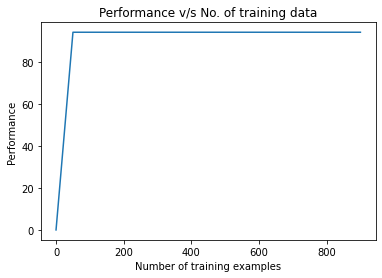

In [ ]:
plot_graph(plot_data)

In [ ]:
def prune_by_subsumption(df):
  evidence_list = list()
  for i, row in df.iterrows():
    curr = row['evidence'].split()
    for k in evidence_list:
      if (set(curr).issubset(set(k))):
        df.drop(i, inplace=True)
        break

    evidence_list.append(curr)
  return df

In [ ]:
df = run_model(base_word, train_data)
df = prune_by_subsumption(df)
result_df, c_c, i_c, accuracy = test(test_data, df)
print("Accuracy = ", accuracy)

Accuracy =  90.0
